# **DATASET**
The dataset for our phishing URL detection project contains 2.5 million entries, including both phishing and legitimate URLs, providing a rich foundation for training machine learning models. It includes key features such as the URL itself, which serves as the basis for extracting structural, statistical, and contextual attributes, and the label, which indicates whether a URL is phishing or legitimate. Structural features include URL length, subdomain count, dot count, and the presence of IP addresses or special characters, all of which are common in phishing URLs. Statistical features, like URL entropy and digit-letter ratio, highlight irregular patterns often found in phishing attempts. Additionally, the dataset captures special characteristics, such as Punycode usage and TLD count, and includes domain-related data like registrar information and domain age, which are useful for identifying suspicious or newly created domains. This comprehensive dataset enables the development of robust machine learning models, such as Logistic Regression, Random Forest, Gradient Boosting, SVM, and Neural Networks, to accurately detect phishing URLs while adapting to evolving cyber threats.

As of recently our dataset was removed from Kaggle: https://www.kaggle.com/datasets/sergioagudelo/phishing-url-detection

# **IMPORTS & CONSTANTS**
This section imports the necessary libraries and modules required for data analysis and model building. It includes standard libraries like `numpy` and `pandas` for data manipulation, `matplotlib` and `seaborn` for visualizations, and `warnings` to suppress unnecessary warnings. Essential modules from `scikit-learn` are also imported, including classifiers such as `SVC`, `MLPClassifier`, `RandomForestClassifier`, `GradientBoostingClassifier`, and `LogisticRegression`, along with tools for model evaluation like `accuracy_score`, `precision_score`, and `roc_curve`. Additionally, functions for model training, hyperparameter tuning (`GridSearchCV`), and data preprocessing (`StandardScaler`) are imported. Lastly, a constant `CHUNKSIZE` is defined for managing large datasets when reading in chunks.

In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn imports
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, confusion_matrix, classification_report
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.filterwarnings('ignore')

# Declaring Constants
CHUNKSIZE = 100000
LABEL_FONT_SIZE = 14
TITLE_FONT_SIZE = 16
LEGEND_FONT_SIZE = 12

# **RETRIEVING DATA**
This section of the code retrieves the dataset either from Google Drive (for Google Colab users) or from a local directory (for users in environments like VS Code). In Google Colab, the Drive is mounted to access the dataset, and it is read in chunks of 1000 rows to manage large files efficiently. After reading the chunks, they are processed and combined into a single DataFrame. For local environments, the dataset is read directly from the local directory. The original dataset is backed up for easy recovery during testing, and the data is reset to this backup for consistency before further processing.

In [ ]:
# Mount Google Drive
from google.colab import drive  
drive.mount('/content/drive')

# Read CSV in chunks (Google Colab)
chunks = pd.read_csv('/content/drive/MyDrive/ds3000/Project/ds3000_group25/Dataset_Group25.csv', chunksize=1000) 

# Process each chunk
df_list = []
for chunk in chunks:
    df_list.append(chunk)

# Combine all chunks back into a single dataframe
data = pd.concat(df_list, ignore_index=True) 

# Copying initial data to quickly recover data during testing
original_data = data.copy()

In [71]:
# Read CSV (Local Environment)
data = pd.read_csv('Dataset_Group25.csv')

# Copying initial data to quickly recover data during testing
original_data = data.copy()

In [72]:
# Resetting data to initial copy (used during testing)
data = original_data.copy()

In [ ]:
# Printing head to show initial structure of dataset
data.head()

# **DATA PREPROCESSING**  
This section preprocesses the dataset to prepare it for model training. Rows with missing values in key columns, such as `url` or `digit_letter_ratio`, are removed. For `domain_age_days`, missing values are replaced with 0, and a binary feature (`has_domain_age`) is created to indicate whether a domain's age is greater than 0. The original `domain_age_days` column is then dropped. Similarly, a binary indicator (`has_whois_data`) is created for the `whois_data` column to flag its presence or absence, after which the original column is dropped. The `label` column is encoded into binary values: 0 for 'legitimate' and 1 for 'phishing'. Boolean columns like `starts_with_ip`, `has_internal_links`, and others are converted to integer representations (0 for False, 1 for True). The `url` and `source` columns, which no longer provide additional information, are dropped. Numerical features, such as `url_length`, `url_entropy`, and others, are standardized using `StandardScaler` to ensure all features are on a similar scale. The preprocessing steps also include sampling a subset of numerical features for visualization of distributions before and after scaling. Once preprocessing is complete, the data is split into training and testing sets, ensuring it is clean, consistent, and ready for model training.


In [74]:
# Drop rows with missing 'url' or 'digit_letter_ratio' (important features)
data = data.dropna(subset=['url', 'digit_letter_ratio'])

# Impute `domain_age_days` missing values with 0
data.loc[:, 'domain_age_days'] = data['domain_age_days'].fillna(0)

# Create a binary indicator for `domain_age_days` (1 if > 0, 0 if 0)
data = data.assign(has_domain_age=(data['domain_age_days'] > 0).astype(int))

# Drop the original `domain_age_days` column
data = data.drop(columns=['domain_age_days'])

# Impute `whois_data` with a binary indicator (1 if not null, 0 if null)
data['has_whois_data'] = data['whois_data'].notnull().astype(int)

# Drop the original `whois_data` column
data = data.drop(columns=['whois_data'])

# Encode the 'label' column as numerical values: 0 for 'legitimate' and 1 for 'phishing'
data['label'] = data['label'].map({'legitimate': 0, 'phishing': 1}).astype(int)

# Convert boolean values to numerical representations (0 for False, 1 for True)
boolean_cols = ['starts_with_ip', 'has_internal_links', 'domain_has_digits', 'has_punycode'] 
for col in boolean_cols:
    if col in data.columns:
        data[col] = data[col].astype(bool).astype(int)

# Drop the 'url' and 'source' columns, as all relevant information has already been extracted
data = data.drop(columns=['url', 'source'])

In [ ]:
# Define numerical columns
numerical_cols = ['url_length', 'url_entropy', 'digit_letter_ratio', 'dot_count', 
                  'at_count', 'dash_count', 'tld_count', 'subdomain_count', 'nan_char_entropy']

# Standardize the entire dataset
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Sample 1% of the data for faster plotting
sample_data = data[numerical_cols].sample(frac=0.01, random_state=0)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the distribution before scaling for each feature
for col in numerical_cols:
    # Apply log transformation to handle large values like 'dash_count'
    log_data = data[col].sample(frac=0.01, random_state=0).apply(lambda x: np.log(x + 1) if x > 0 else 0)
    sns.histplot(log_data, ax=axes[0], kde=True, bins=50, label=col)

axes[0].set_title("Before Scaling (Log Transformed)", fontsize=TITLE_FONT_SIZE)
axes[0].set_xlabel("Value", fontsize=LABEL_FONT_SIZE)
axes[0].set_ylabel("Frequency", fontsize=LABEL_FONT_SIZE)
axes[0].legend(title="Features", fontsize=LEGEND_FONT_SIZE)  

# Plot the distribution after scaling for each feature
for col in numerical_cols:
    # Apply log transformation to the scaled sample data
    log_scaled_data = sample_data[col].apply(lambda x: np.log(x + 1) if x > 0 else 0)
    sns.histplot(log_scaled_data, ax=axes[1], kde=True, bins=50, label=col)

axes[1].set_title("After Scaling (Log Transformed)", fontsize=TITLE_FONT_SIZE)
axes[1].set_xlabel("Scaled Value", fontsize=LABEL_FONT_SIZE)
axes[1].set_ylabel("Frequency", fontsize=LABEL_FONT_SIZE)
axes[1].legend(title="Features", fontsize=LABEL_FONT_SIZE) 

# Adjust layout for better display
plt.tight_layout()
plt.show()

In [ ]:
# Display processed structure of dataset
data.head()

In [ ]:
# Ensure there is no null variables in the dataframe
data.isnull().sum()

In [ ]:
# Define the predictor variables and the outcome variable
X = data.drop(columns=['label'])  # All features except the target
y = data['label']  # Response variable

# Split the data into train and test sets (20% holdout for test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Check the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# **EXPLORATORY DATA ANALYSIS (EDA)**
This exploratory data analysis (EDA) investigates the dataset's characteristics by visualizing relationships among numerical features through a pair plot and generating statistical summaries with `data.describe()`. A correlation matrix heatmap is used to identify linear relationships between features, while the Variance Inflation Factor (VIF) is calculated to assess multicollinearity. The class distribution of legitimate and phishing URLs is displayed with a customized count plot, with annotations indicating class counts. This analysis helps uncover key patterns, feature redundancies, and class imbalances, providing valuable insights for feature selection and further preprocessing steps.

In [ ]:
# Select only the numerical columns (data frames)
numerical_columns = data[['url_length', 'url_entropy', 'digit_letter_ratio', 'dot_count', 
                          'at_count', 'dash_count', 'tld_count', 'subdomain_count', 'nan_char_entropy']]

# Sample 5% of the data for faster plotting
subset_data = numerical_columns.sample(frac=0.01, random_state=0)

# Create a pairplot for the sampled data
sns.pairplot(subset_data, height=4)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Describe data to get meaningful statistics on numerical features (i.e., count, mean, etc)
data.describe()

In [ ]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Draw a heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Add labels and a title
plt.title("Correlation Matrix Heatmap", fontsize=TITLE_FONT_SIZE)  # Title for the heatmap
plt.xlabel("Features", fontsize=LABEL_FONT_SIZE)  # Label for the x-axis
plt.ylabel("Features", fontsize=LABEL_FONT_SIZE)  # Label for the y-axis

# Show the plot
plt.show()

In [ ]:
# Calculate Variance Inflation Factor (VIF) to check for multicollinearity among the features
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns  # Feature names
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]  # Calculate VIF for each feature

# Print the VIF values for each feature
print(vif_data)

In [ ]:
# Create the count plot 
plt.figure(figsize=(8, 6))  # Set figure size

# Plot the count plot with custom red and green color palette (Christmas is here!)
sns.countplot(x='label', data=data, palette=['green', 'red'])

# Add title, labels, and adjust font size for better readability
plt.title('Class Distribution: Legitimate (0) vs Phishing (1)', fontsize=TITLE_FONT_SIZE)
plt.xlabel('Class', fontsize=LABEL_FONT_SIZE)
plt.ylabel('Count', fontsize=LABEL_FONT_SIZE)

# Annotate the bars with the count values
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', 
                       fontsize=LEGEND_FONT_SIZE, color='black', 
                       xytext=(0, 9), textcoords='offset points')

# Adjust the layout to ensure everything fits nicely
plt.tight_layout()

# Display the plot
plt.show()


### **UTILITY METHODS**
The utility methods provided serve various purposes to evaluate and visualize machine learning models. The `plot_scatter` function compares actual vs predicted outcomes and predicted probabilities, with the option to sample the test data for large datasets. The `print_classification_metrics` method calculates and displays accuracy, precision, recall, F1 score, and a confusion matrix heatmap. The `confusion_matrix_heatmap` function visualizes the confusion matrix using a heatmap. `plot_feature_importance` shows the importance of features based on model coefficients (for Logistic Regression) or feature importances (for tree-based models). The `plot_precision_recall_curve` plots the Precision-Recall curve and computes the average precision score, which is more useful in cases of class imbalance. `evaluate_best_model` evaluates the given model by plotting predictions, metrics, feature importance, and the Precision-Recall curve. Finally, `perform_grid_search` performs a grid search with Stratified K-Fold cross-validation to find optimal hyperparameters based on recall. Each function is equipped with comments to explain key steps, like plotting, metric calculations, and model evaluations.

In [226]:
# Plot scatter of predicted/actual outcomes and their probabilities
def plot_scatter(model, X_test, y_test, sample_size=300):
    # Predict the classes for the test set
    y_pred = model.predict(X_test)
    # Predict the probabilities for the positive class (class 1)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Randomly sample a subset of the data to avoid overcrowding the plot
    if len(X_test) > sample_size:
        sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
        X_test_sample = X_test.iloc[sample_indices]
        y_test_sample = y_test.iloc[sample_indices]
        y_pred_sample = y_pred[sample_indices]
        y_pred_proba_sample = y_pred_proba[sample_indices]
    else:
        X_test_sample = X_test
        y_test_sample = y_test
        y_pred_sample = y_pred
        y_pred_proba_sample = y_pred_proba

    # Add slight jitter to the x-axis for better visibility
    jitter = 0.05  # Adjust jitter for separation of points
    jittered_indices = np.arange(len(y_test_sample)) + np.random.normal(0, jitter, len(y_test_sample))

    # Create a scatter plot for actual vs predicted outcomes and probabilities
    plt.figure(figsize=(9, 4.5))
    plt.scatter(jittered_indices, y_test_sample, alpha=0.7, label='Actual Outcomes', color='blue', s=50, marker='o')  # Make actual outcomes visible
    plt.scatter(jittered_indices, y_pred_sample, alpha=0.7, label='Predicted Outcomes', color='orange', s=50, marker='x')  # Make predicted outcomes visible
    plt.scatter(jittered_indices, y_pred_proba_sample, alpha=0.3, label='Predicted Probabilities', color='green', s=30, marker='^')  # Least visible for probabilities
    
    # Plot enhancements
    plt.grid(True, linestyle='-', alpha=0.7)
    plt.title(f'Model Predictions vs Actual Outcomes', fontsize=16)
    plt.xlabel('Sample Index', fontsize=14)
    plt.ylabel('Prediction (0 or 1)', fontsize=14)
    plt.legend(loc='center right', fontsize=12)
    plt.tight_layout()
    plt.show()

    return y_pred


# Print classification metrics
def print_classification_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Print Confusion Matrix
    print("=" * 117)
    print(f"{'Confusion Matrix':^117}")
    print("-" * 117)
    print(f"{'True Negative (TN)':<25}: {tn}")
    print(f"{'False Positive (FP)':<25}: {fp}")
    print(f"{'False Negative (FN)':<25}: {fn}")
    print(f"{'True Positive (TP)':<25}: {tp}")
    print("=" * 117)

    # Print Metrics
    print(f"{'Metrics':^117}")
    print("-" * 117)
    print(f"{'Accuracy':<25}: {accuracy_score(y_test, y_pred):.4f}")
    print(f"{'Precision':<25}: {precision_score(y_test, y_pred):.4f}")
    print(f"{'Recall':<25}: {recall_score(y_test, y_pred):.4f}")
    print(f"{'F1 Score':<25}: {f1_score(y_test, y_pred):.4f}")
    print("=" * 117)

    # Classification Report
    print(f"{'Classification Report':^117}")
    print("-" * 117)
    print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))
    print("=" * 117)

    # Plot confusion matrix heatmap
    confusion_matrix_heatmap(y_test, y_pred)

# Plot confusion matrix heatmap
def confusion_matrix_heatmap(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(9.5, 4.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title('Confusion Matrix Heatmap', fontsize=TITLE_FONT_SIZE)
    plt.xlabel('Predicted', fontsize=LABEL_FONT_SIZE)
    plt.ylabel('Actual', fontsize=LABEL_FONT_SIZE)
    plt.tight_layout()
    plt.show()

# Function to plot feature importance
def plot_feature_importance(model, feature_names):
    # Check if the model has coefficients (e.g., linear models)
    if hasattr(model, 'coef_'):
        coefficients = model.coef_.flatten()
        feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
        feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
        feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

        # Print top features by importance
        print("\n" + "=" * 117)
        print(f"{'Top Features by Importance':^117}")
        print("-" * 117)
        print(feature_importance.head(10))
        print("=" * 117)

        # Plot feature importance with vibrant color palette
        plt.figure(figsize=(9, 4.5))
        ax = sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance, palette='viridis')
        plt.title("Feature Importance (Absolute Coefficients)", fontsize=TITLE_FONT_SIZE)
        plt.xlabel("Absolute Coefficient Value", fontsize=LABEL_FONT_SIZE)
        plt.ylabel("Feature Name", fontsize=LABEL_FONT_SIZE)

        # Extend x-axis margin to avoid annotation cutoff
        ax.set_xlim(right=ax.get_xlim()[1] * 1.1)  # Increase x-limit by 10%

        # Annotate the bars with values, adding margin for readability
        for p in ax.patches:
            value = p.get_width()
            ax.annotate(f'{value:.2f}', 
                        (p.get_x() + p.get_width() + 0.02, p.get_y() + p.get_height() / 2),  # Added margin
                        xytext=(5, 0),  # Adjust text offset
                        textcoords='offset points', 
                        ha='left', va='center', fontsize=LEGEND_FONT_SIZE, color='black')

        plt.tight_layout()
        plt.show()

    # Check if the model has feature importances (e.g., tree-based models)
    elif hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        # Print top features by importance
        print("\n" + "=" * 117)
        print(f"{'Top Features by Importance':^117}")
        print("-" * 117)
        print(feature_importance.head(10))
        print("=" * 117)

        # Plot feature importance with vibrant color palette
        plt.figure(figsize=(9, 4.5))
        ax = sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
        plt.title("Feature Importance", fontsize=TITLE_FONT_SIZE)
        plt.xlabel("Importance Value", fontsize=LABEL_FONT_SIZE)
        plt.ylabel("Feature Name", fontsize=LABEL_FONT_SIZE)

        # Extend x-axis margin to avoid annotation cutoff
        ax.set_xlim(right=ax.get_xlim()[1] * 1.1)  # Increase x-limit by 10%

        # Annotate the bars with values, adding margin for readability
        for p in ax.patches:
            value = p.get_width()
            ax.annotate(f'{value:.2f}', 
                        (p.get_x() + p.get_width() + 0.02, p.get_y() + p.get_height() / 2),  # Added margin
                        xytext=(5, 0),  # Adjust text offset
                        textcoords='offset points', 
                        ha='left', va='center', fontsize=LEGEND_FONT_SIZE, color='black')

        plt.tight_layout()
        plt.show()
        
def plot_precision_recall_curve(model, X_test, y_test):
    # Predict probabilities for the positive class (class 1)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    
    # Compute average precision score (AP)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    # Print precision-recall score
    print("=" * 117)
    print(f"{'Precision-Recall Curve':^117}")
    print("-" * 117)
    print(f"{'Average Precision Score:':<25}: {avg_precision:.4f}")
    print("=" * 117)

    # Plot the Precision-Recall curve
    plt.figure(figsize=(9, 4.5))
    plt.plot(recall, precision, color='blue', lw=2, label=f'{model.__class__.__name__}')
    plt.plot([0, 1], [0.5, 0.5], color='red', linestyle='--', label='No skill')

    # Add title, labels, and legend
    plt.title('Precision-Recall Curve', fontsize=16)
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.legend(loc='center left', fontsize=12)
    plt.tight_layout()
    plt.show()

# Evaluate the best model
def evaluate_best_model(best_model):
    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
    y_pred_test = best_model.predict(X_test)

    test_score = recall_score(y_test, y_pred_test)
    print("=" * 117)
    print(f"{'Test Set Recall':^117}")
    print("-" * 117)
    print(f"{'Recall':<25}: {test_score:.4f}")
    print("=" * 117)

    # Plot scatter of predictions vs outcomes
    y_pred = plot_scatter(best_model, X_test, y_test)

    # Print classification metrics
    print_classification_metrics(y_test, y_pred)

    # Plot PR curve
    plot_precision_recall_curve(best_model, X_test, y_test)
    
    # Plot feature importance
    plot_feature_importance(best_model, feature_names)
    print("=" * 117)

# Function to perform grid search with 5 Stratified K-Fold cross-validation
def perform_grid_search(model, param_grid, n_jobs=-1):
    cv = StratifiedKFold(n_splits=5)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='recall', n_jobs=n_jobs)
    grid_search.fit(X_train, y_train)

    print("=" * 117)
    print(f"{'Optimal Parameters Found':^117}")
    print("-" * 117)
    print(f"{'Best Params':<25}: {grid_search.best_params_}")
    print(f"{'Best 5-CV Recall Score':<25}: {grid_search.best_score_:.4f}")
    print("=" * 117)

    return grid_search.best_estimator_


# **LOGISTIC REGRESSION**
In this section, a Logistic Regression (LR) model is defined and optimized for binary classification. The model is configured with `max_iter=10` to limit the number of iterations and `class_weight='balanced'` to address class imbalances. The parameter grid for the grid search includes various regularization techniques (`penalty`: L1, L2, elasticnet), the regularization strength (`C`), and solver choices (`solver`: liblinear, lbfgs, saga). For elasticnet, the `l1_ratio` hyperparameter is also tuned to balance L1 and L2 regularization. Using 5-fold cross-validation, the best set of hyperparameters is identified, and the model's performance is evaluated on the test set, with metrics like recall, accuracy, and AUROC being calculated. The section ensures the LR model is fine-tuned for optimal performance on the dataset, with evaluation results and visualizations provided.

In [ ]:
# Define the logistic regression model
LR_model = LogisticRegression(max_iter=10, class_weight='balanced')

# Define the parameter grid for logistic regression
param_grid = [
    {
        'penalty': ['l1'],  # Regularization type
        'C': [0.1, 1, 10],  # Regularization strength (inverse)
        'solver': ['liblinear', 'saga'] # Optimization algorithm
    },
    {
        'penalty': ['l2'],
        'C': [0.1, 1, 10],
        'solver': ['lbfgs', 'liblinear', 'saga']
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.1, 1, 10],
        'l1_ratio': [0.2, 0.5, 0.8] # Balance between L1 and L2 regularization
    }
]


# Performing grid search with 5 k-fold validation to find best LR model
LR_best_model = perform_grid_search(LR_model, param_grid, -1)

In [ ]:
# Evaluating test set on best LR model
evaluate_best_model(LR_best_model)

# **RANDOM FOREST**

In [ ]:
# Define the Random Forest model
RF_model = RandomForestClassifier(class_weight='balanced', random_state=0)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [10, 20, 40],  # Number of trees
    'max_depth': [5, 10],   # Max depth of trees
    'min_samples_split': [2, 5],   # Min samples required to split an internal node
    'min_samples_leaf': [1, 2],     # Min samples required at a leaf node
}

# Performing grid search with 5 k-fold validation to find best RF model
RF_best_model = perform_grid_search(RF_model, param_grid, -1)

In [ ]:
# Evaluating test set on best RF model
evaluate_best_model(LR_best_model)

# **GRADIENT BOOSTING**

In [212]:
# Define the Gradient Boosting model
GB_model = GradientBoostingClassifier(random_state=0)

# Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [10, 20],  # Number of boosting stages
    'learning_rate': [0.1, 0.2],  # Step size shrinkage
    'max_depth': [3, 5]  # Maximum depth of each tree
}

# Performing grid search with 5 k-fold validation to find best GB model
GB_best_model = perform_grid_search(GB_model, param_grid, -1)

                                              Optimal Parameters Found                                               
---------------------------------------------------------------------------------------------------------------------
Best Params              : {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 20}
Best 5-CV Recall Score   : 1.0000


                                                   Test Set Recall                                                   
---------------------------------------------------------------------------------------------------------------------
Recall                   : 1.0000


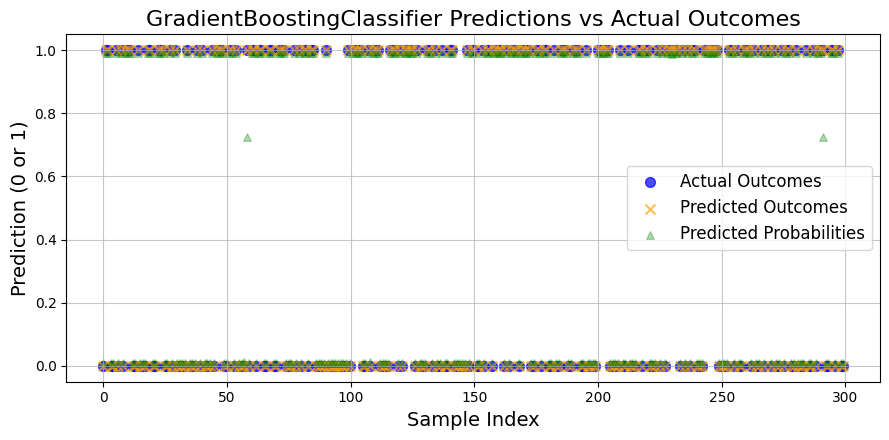

                                                  Confusion Matrix                                                   
---------------------------------------------------------------------------------------------------------------------
True Negative (TN)       : 249903
False Positive (FP)      : 1
False Negative (FN)      : 9
True Positive (TP)       : 250087
                                                       Metrics                                                       
---------------------------------------------------------------------------------------------------------------------
Accuracy                 : 1.0000
Precision                : 1.0000
Recall                   : 1.0000
F1 Score                 : 1.0000
                                                Classification Report                                                
---------------------------------------------------------------------------------------------------------------------
              precision    rec

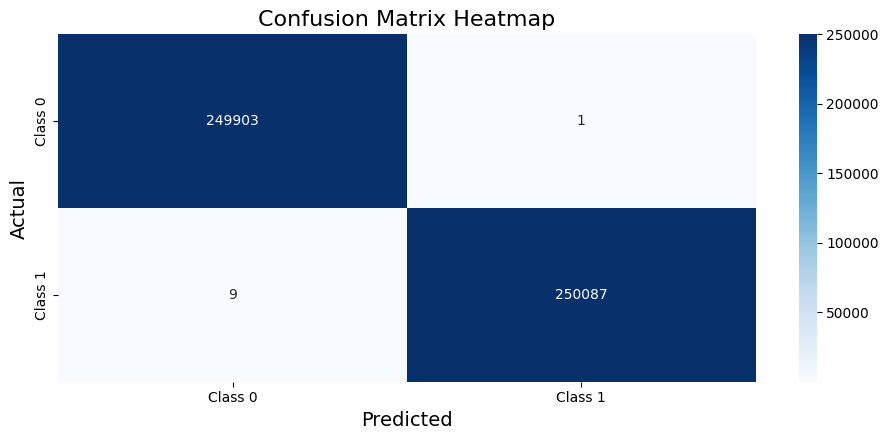

                                               Precision-Recall Curve                                                
---------------------------------------------------------------------------------------------------------------------
Average Precision Score: : 1.0000


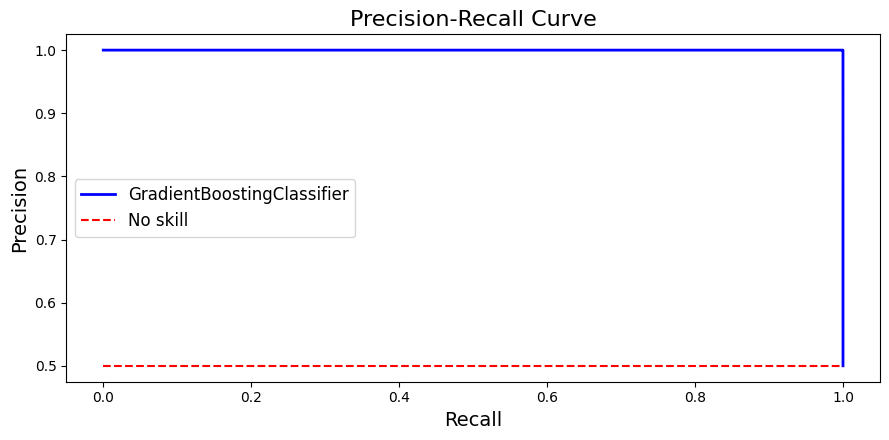


                                             Top Features by Importance                                              
---------------------------------------------------------------------------------------------------------------------
               Feature    Importance
11    nan_char_entropy  8.025956e-01
0           url_length  1.796848e-01
10     subdomain_count  1.284171e-02
2          url_entropy  2.857027e-03
5            dot_count  2.007370e-03
13      has_domain_age  1.056914e-05
4   digit_letter_ratio  2.931792e-06
9    domain_has_digits  1.153480e-21
6             at_count  0.000000e+00
1       starts_with_ip  0.000000e+00


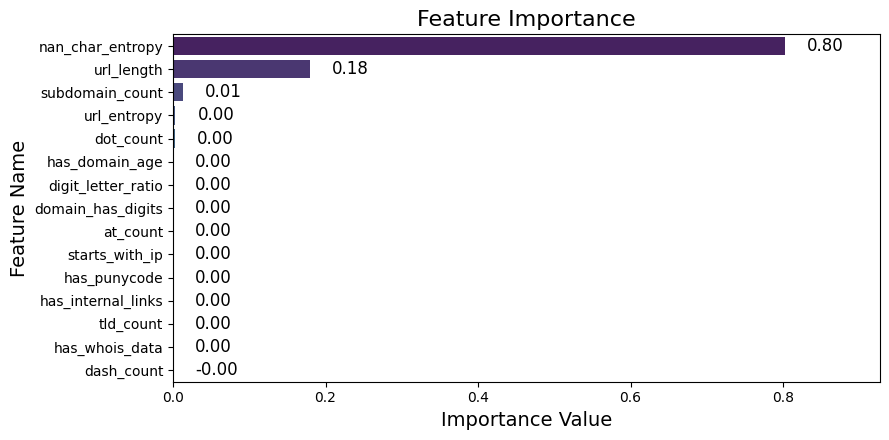

In [225]:
# Evaluating test set on best GB model
evaluate_best_model(GB_best_model)

# **SUPPORT VECTOR MACHINE (SVM)**

In [ ]:
# Define the SVM model
SVM_model = SVC(probability=True, max_iter=10, random_state=0)

# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10], # Regularization strength (inverse)
    'kernel': ['rbf', 'poly', 'sigmoid'], # Kernel function to use
    'gamma': ['scale', 'auto', 0.01]    # Kernel coefficient
}

# Performing grid search with 5 k-fold validation to find best SVM model
SVM_best_model = perform_grid_search(SVM_model, param_grid, -1)

In [ ]:
# Evaluating test set on best SVM model
evaluate_best_model(SVM_best_model)

# **NEURAL NETWORK (MLP)**

In [ ]:
# Define the MLP (Multi-layer Perceptron) model
MLP_model = MLPClassifier(random_state=0, max_iter=10)
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (20, 10)], # Number of neurons in each hidden layer
    'activation': ['relu'], # Activation function used in the hidden layers
    'solver': ['adam','sgd','lbfgs'],   # Optimizer used to minimize the loss function
    'alpha': [0.0001,0.01]  # Regularization term
}

# Performing grid search with 5 k-fold validation to find best MLP model
MLP_best_model = perform_grid_search(MLP_model, param_grid, -1)

In [ ]:
# Evaluating test set on best MLP model
evaluate_best_model(MLP_best_model)

# **Best Model**
